<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Mehrdad Nasri nahar
### Student ID: 98102498

# Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 76375537.55it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 60146819.18it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 29017036.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13340706.42it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

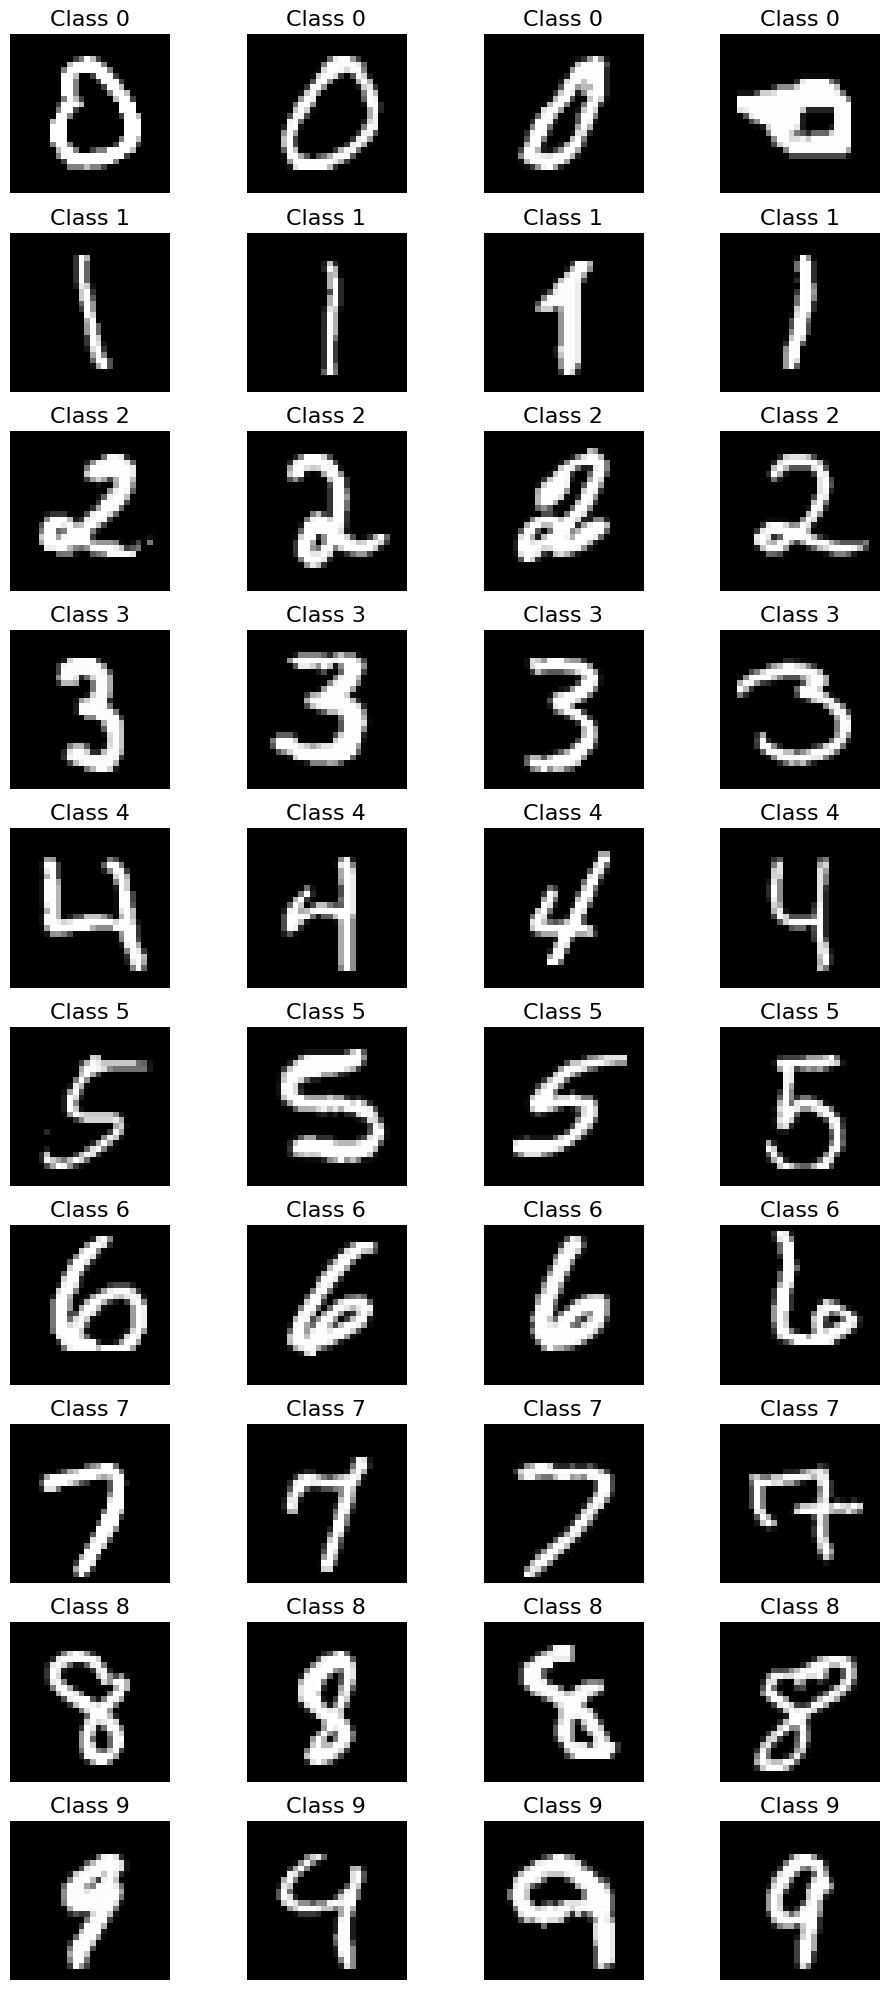

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [5]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
      super(VAE_MLP, self).__init__()
      self.encoder = nn.Sequential(
          nn.Linear(input_dim , hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim , hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim , hidden_dim),
          nn.ReLU()
      )

      self.fc_mu = nn.Linear(hidden_dim , latent_dim)
      self.fc_logvar = nn.Linear(hidden_dim , latent_dim)

      self.decoder = nn.Sequential(
          nn.Linear(latent_dim , hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim , hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim , hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim , input_dim),
          nn.Sigmoid()
      )

    def reparameterize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      epsilon = torch.randn_like(std)
      reparameterization_out = mu + epsilon*std
      return reparameterization_out

    def forward(self, x):
      enc_out = self.encoder(x)
      mu_out = self.fc_mu(enc_out)
      logvar_out = self.fc_logvar(enc_out)
      z = self.reparameterize(mu_out,logvar_out)
      dec_out = self.decoder(z)

      return dec_out , mu_out , logvar_out


In [6]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # Reconstruction Loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')
    # KL Divergence Loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - (mu*mu) - torch.exp(logvar))
    # Loss VAE
    VAE_loss = reconstruction_loss + kl_divergence
    return VAE_loss

In [7]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(-1,784)
            output , mu , logvar = model(data)
            recon = output.view(-1,784)

            loss = vae_loss(recon , data , mu , logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")


##################################################
VAE-MLP Epoch [1/10], Loss: 11715.61399232909
Sample Images:


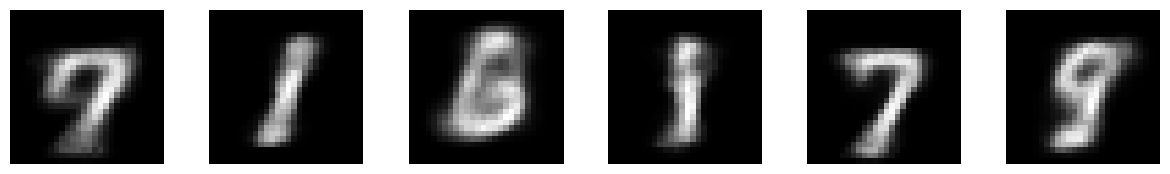


##################################################
VAE-MLP Epoch [2/10], Loss: 10003.895627019756
Sample Images:


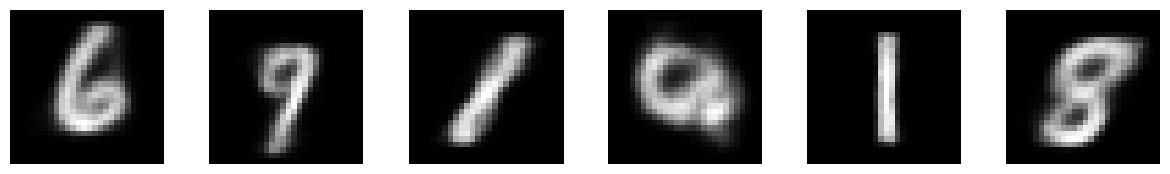


##################################################
VAE-MLP Epoch [3/10], Loss: 9623.94793558019
Sample Images:


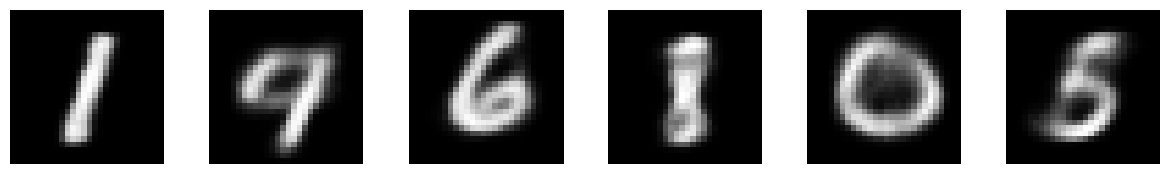


##################################################
VAE-MLP Epoch [4/10], Loss: 9410.89193940315
Sample Images:


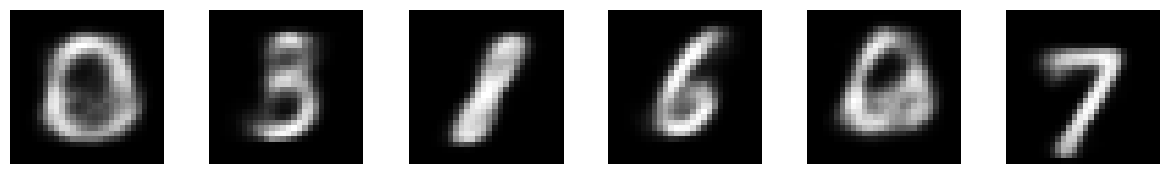


##################################################
VAE-MLP Epoch [5/10], Loss: 9307.981205856877
Sample Images:


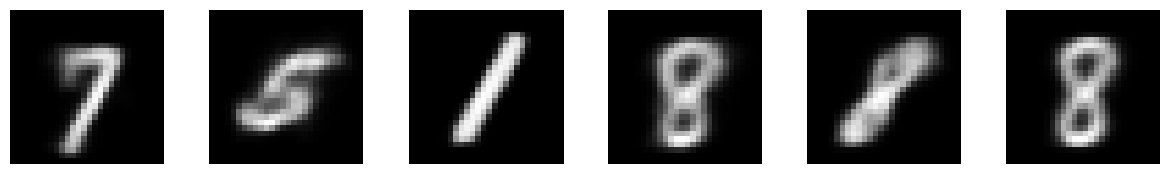


##################################################
VAE-MLP Epoch [6/10], Loss: 9228.995705936
Sample Images:


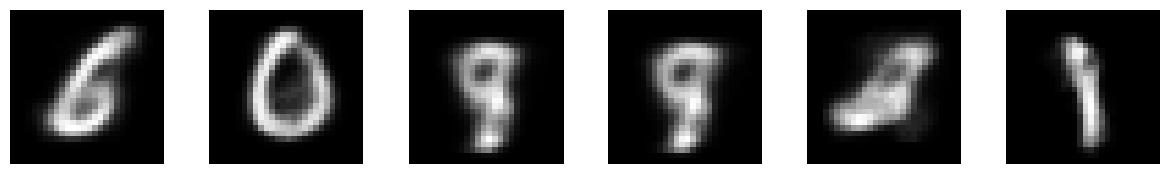


##################################################
VAE-MLP Epoch [7/10], Loss: 9167.325574277053
Sample Images:


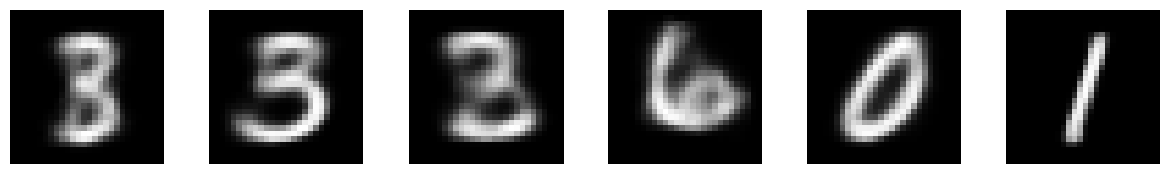


##################################################
VAE-MLP Epoch [8/10], Loss: 9108.808931070096
Sample Images:


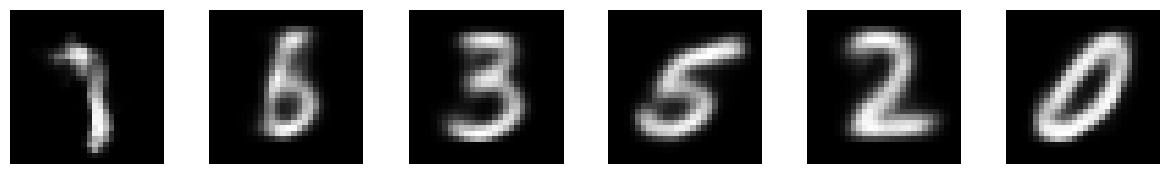


##################################################
VAE-MLP Epoch [9/10], Loss: 9055.327561238173
Sample Images:


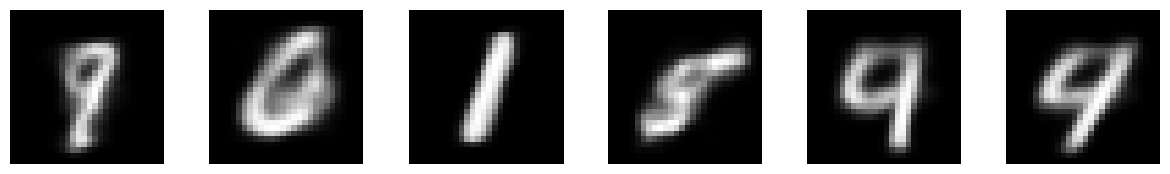


##################################################
VAE-MLP Epoch [10/10], Loss: 9044.373891736906
Sample Images:


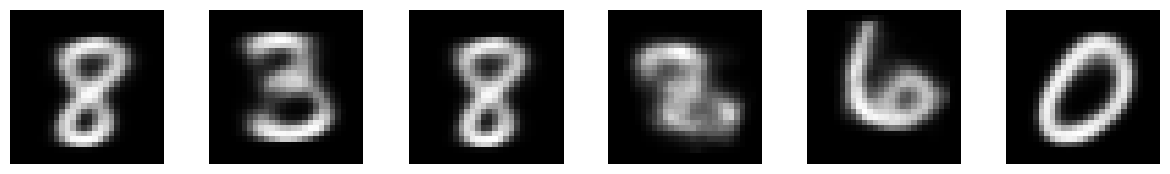

Best model saved as 'best_vae_mlp_model.pth'


In [8]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [10]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        self.encoder = nn.Sequential(
          nn.Linear(input_dim + num_classes , hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim , hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim , hidden_dim),
          nn.ReLU()
          )
        self.fc_mu = nn.Linear(hidden_dim , latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim , latent_dim)
        self.fc_class = nn.Linear(latent_dim, num_classes)

        self.decoder = nn.Sequential(
          nn.Linear(latent_dim + num_classes , hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim , hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim , hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim , input_dim),
          nn.Sigmoid()
          )

    def reparameterize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      epsilon = torch.randn_like(std)
      reparameterization_out = mu + epsilon*std
      return reparameterization_out

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)
        x = torch.cat([x,y], dim=1)

        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu,logvar)
        class_logits = self.fc_class(z)
        reconstructed = self.decoder(torch.cat([z,y], dim=1))

        return reconstructed, mu, logvar, class_logits


In [11]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    data = data.view(-1,784)
    # reconstruction loss
    reconstruction_loss = F.binary_cross_entropy(recon, data, reduction='sum')
    # KL Divergence Loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - (mu*mu) - torch.exp(logvar))
    ce_loss = F.cross_entropy(class_logits, labels, reduction='sum')
    # Total loss
    CVAE_loss = reconstruction_loss + kl_divergence + ce_loss
    return CVAE_loss

In [12]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = F.one_hot(labels, num_classes=10).float()

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            # recon = None
            # mu = None
            # logvar = None
            # class_logits = None
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels)

            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 10980.00591767724
Sample Images:


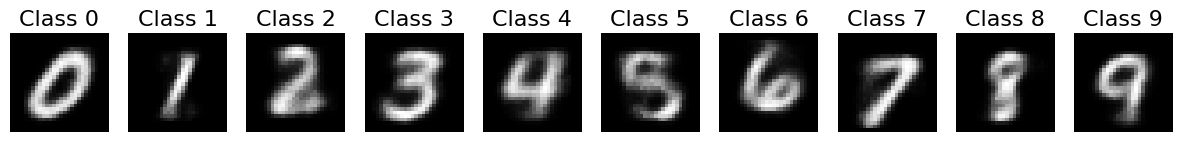


##################################################
CVAE-MLP Epoch [2/10], Loss: 9108.004260488156
Sample Images:


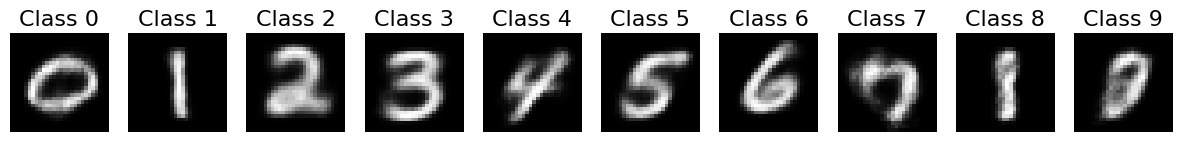


##################################################
CVAE-MLP Epoch [3/10], Loss: 8808.599759295043
Sample Images:


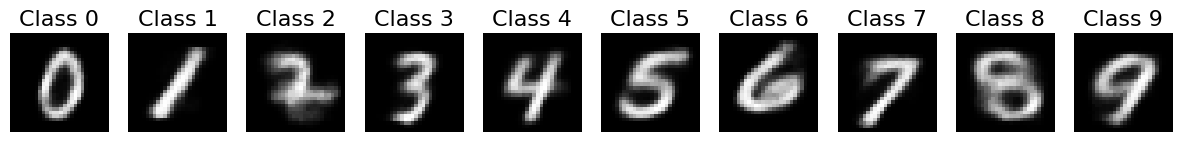


##################################################
CVAE-MLP Epoch [4/10], Loss: 8683.131934843084
Sample Images:


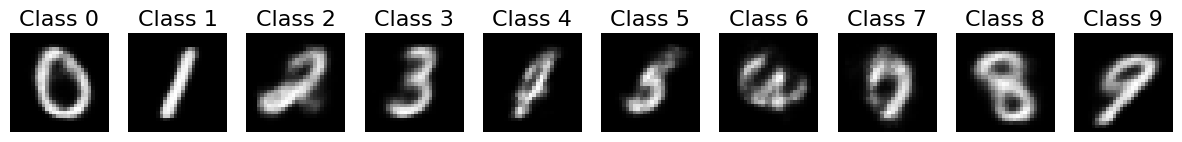


##################################################
CVAE-MLP Epoch [5/10], Loss: 8611.09170473664
Sample Images:


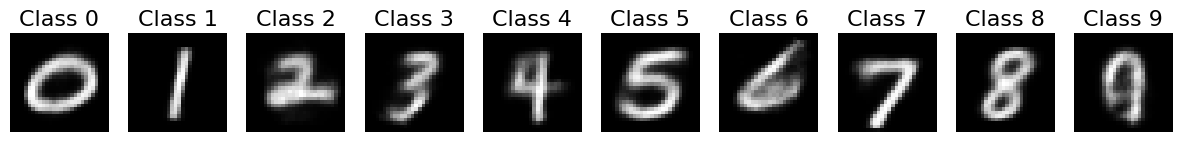


##################################################
CVAE-MLP Epoch [6/10], Loss: 8570.54765036772
Sample Images:


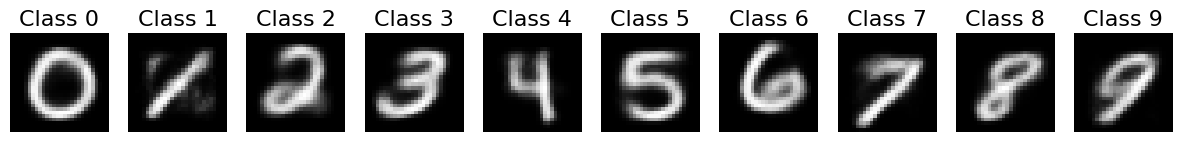


##################################################
CVAE-MLP Epoch [7/10], Loss: 8540.054584950527
Sample Images:


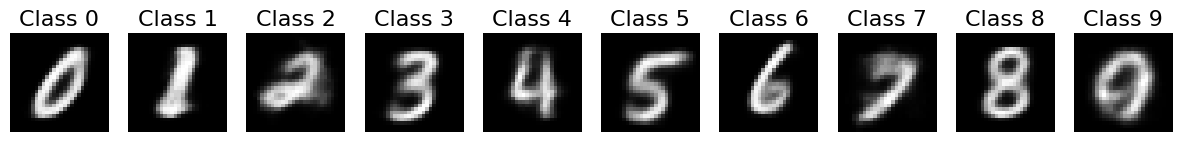


##################################################
CVAE-MLP Epoch [8/10], Loss: 8558.809093483476
Sample Images:


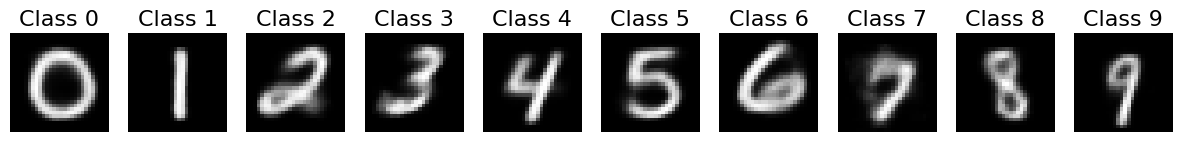


##################################################
CVAE-MLP Epoch [9/10], Loss: 8479.297696957456
Sample Images:


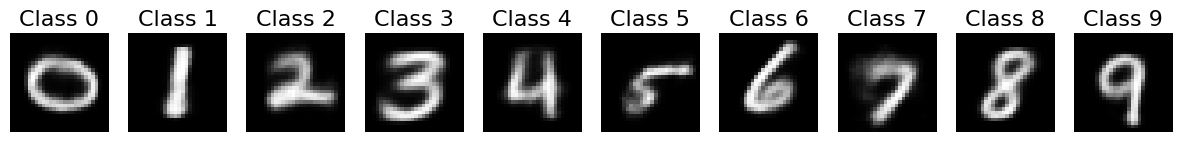


##################################################
CVAE-MLP Epoch [10/10], Loss: 8449.147811271489
Sample Images:


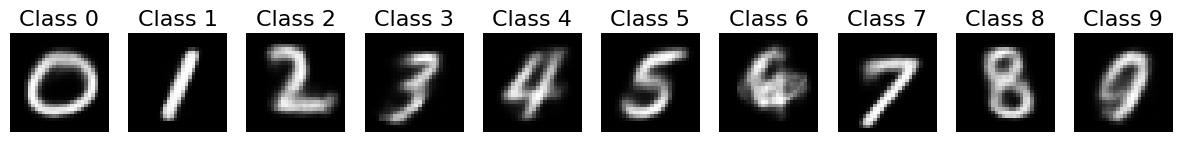

Best model saved as 'best_cvae_mlp_model.pth'


In [13]:
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim=256, latent_dim=2, num_classes=10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


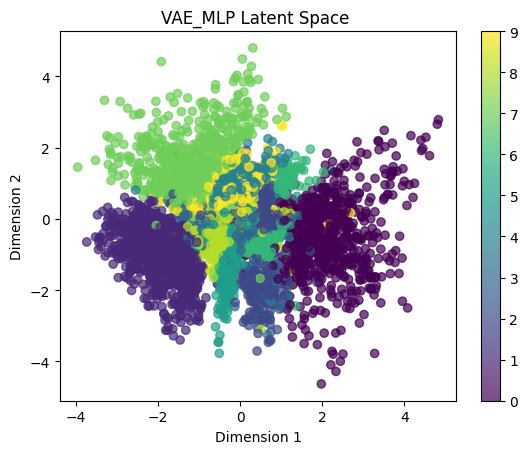

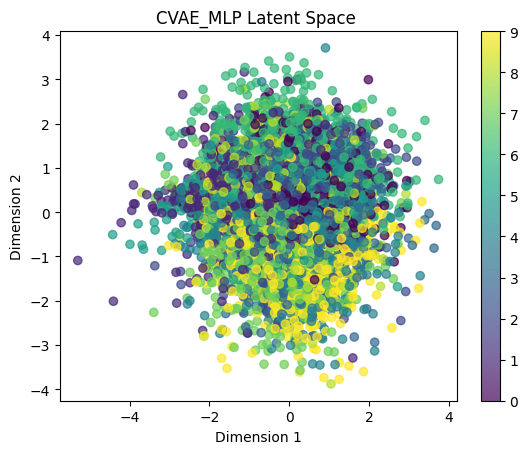

In [17]:
# Define a function to visualize the latent space
def visualize_latent_space(model, data_loader, is_vae = True):
    model.eval()
    all_data = []
    all_labels = []
    num_batches = 128
    counter = 0

    with torch.no_grad():
        for data, labels in data_loader:
            data = data.view(-1, 784)
            if is_vae:
              _, mu, _ = model(data)
              all_data.append(mu)
              all_labels.append(labels)
              counter = counter + 1
              if counter >= num_batches:
                break
            else:
              data = data.view(-1, 784)
              y = F.one_hot(labels, num_classes=10).float()
              _, mu, _, _ = model(data, y)
              all_data.append(mu)
              all_labels.append(labels)
              counter = counter + 1
              if counter >= num_batches:
                break
    all_data = torch.cat(all_data, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    plt.scatter(all_data[:, 0], all_data[:, 1], c=all_labels, cmap='viridis', alpha=0.7)
    plt.colorbar()
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    if is_vae:
      plt.title('VAE_MLP Latent Space ')
    else:
      plt.title('CVAE_MLP Latent Space ')
    plt.show()

# Visualize Latent Space for VAE
visualize_latent_space(vae_mlp, train_loader ,is_vae = True)

# # Visualize Latent Space for CVAE
visualize_latent_space(cvae_mlp, train_loader, is_vae = False)

با توجه به اسلایدهای استاد و مفاهیم درس، می دانیم در مدل اول ورودی ها به یک توزیع احتمال مپ می شوند و بدین ترتیب ورودی های مشابه به نقاط نزدیک به هم در فضا پنهان مپ می شوند و در واقع ورودی های مشابه به یک توزیع احتمال مربوط به آن ورودی ها مپ می شوند. در مدل دوم علاوه بر ورودی موردنظر ، یک شرط نیز داریم. در واقع فضا پنهان علاوه بر ورودی ها تحت تاثیر شرط ورودی نیز می باشد. این مدل در واقع ورودی ها را به یک توزیع احتمال مپ می کند که ساختار آن دارای یک قید شرط(کاندیشن) نیز می باشد. در واقع به گونه ای مشابه یک مدل میکسچر می شود ولی خب دقیقا میکسچر نیست. حال با توجه به ورودی و شرط ورودی که می تواند برچسب کلاس ها در مسئله موردنظر باشد، شبکه ورودی و شرط آن را به یک توزیع احتمال کلی مپ می کند. بدین ترتیب می توان انتظار داشت با توجه به وجود کاندیشن و ساختار این مدل ، تراکم زیاد در فضا پنهان در مدل دوم نرمال می باشد. در واقع ساختار این فضا تحت تاثیر قید مشخصی می باشد و بدین ترتیب شبکه می تواند خروجی مناسب تولید کند. پس این تفاوت موجود در تراکم و نوع خوشه بندی در فضا پنهان دو شبکه با توجه به نوع آموزش این دو و اینکه یکی از آن ها تحت تاثیر شرطی مشخص آموزش داده می شود طبیعی می باشد.

مدل اول = VAE

مدل دوم =CVAE